<a href="https://colab.research.google.com/github/PriyanshuRao-code/AI-Lab-Project/blob/Armaan/team_24_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Don't do anything here. It's just a setup.
import os
import sys

repo_name = "AI-Lab-Project"
repo_url = "https://github.com/PriyanshuRao-code/AI-Lab-Project.git"
repo_path = f"/content/{repo_name}"

if os.path.exists(repo_path):
    print("Repository already exists at:", repo_path)
else:
    print("🚀 Cloning the repository...")
    os.system(f"git clone {repo_url}")

os.chdir(repo_path)
sys.path.append(repo_path)

print("Repository is ready to use at:", repo_path)

Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project


In [6]:
branch_name = "Armaan"

!git clone --branch {branch_name} --single-branch {repo_url}

fatal: destination path 'AI-Lab-Project' already exists and is not an empty directory.


In [7]:
# Start coding from here.

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns

In [9]:
df = pd.read_csv('24.csv')

In [10]:
!pip install import-ipynb
import import_ipynb
from team_24_data_preprocessing import data_preprocessing
normal_train, normal_valid, normal_test = data_preprocessing(df)

Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project


In [11]:
target_column = "Hazardous"

In [12]:
X_train = normal_train.drop(columns=[target_column])
y_train = normal_train[target_column]

In [13]:
X_valid = normal_valid.drop(columns=[target_column])
y_valid = normal_valid[target_column]

In [14]:
X_test = normal_test.drop(columns=[target_column])
y_test = normal_test[target_column]

In [15]:

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("X_test shape:", X_test.shape)

X_train shape: (2512, 26)
X_valid shape: (837, 26)
X_test shape: (838, 26)


In [16]:
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)
print("y_test shape:", y_test.shape)

y_train shape: (2512,)
y_valid shape: (837,)
y_test shape: (838,)


In [17]:
print(f"Total samples: {len(y_train) + len(y_valid) + len(y_test)}")
print(f"Original dataset size: {df.shape[0]}")

Total samples: 4187
Original dataset size: 4687


In [18]:
print("\nMissing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in y_train:", y_train.isnull().sum())


Missing values in X_train: 0
Missing values in y_train: 0


In [19]:
print(f"\n Data Shapes: Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")


 Data Shapes: Train: (2512, 26), Valid: (837, 26), Test: (838, 26)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

In [37]:
X_train["Close Approach Date"] = X_train["Close Approach Date"].astype("int64") // 10**9  # Convert to seconds
X_valid["Close Approach Date"] = X_valid["Close Approach Date"].astype("int64") // 10**9
X_test["Close Approach Date"] = X_test["Close Approach Date"].astype("int64") // 10**9

In [39]:
X_train["Orbit Determination Date"] = pd.to_datetime(X_train["Orbit Determination Date"]).astype("int64") // 10**9
X_valid["Orbit Determination Date"] = pd.to_datetime(X_valid["Orbit Determination Date"]).astype("int64") // 10**9
X_test["Orbit Determination Date"] = pd.to_datetime(X_test["Orbit Determination Date"]).astype("int64") // 10**9


In [41]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

In [43]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)

In [67]:
def train_model_perceptron(X_train_t, X_valid_t, X_test_t, y_train_t, y_valid_t, y_test_t, model, num_epochs=100, lr=0.01):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [69]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\nEvaluation Metrics for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

    return accuracy, precision, recall, f1

In [70]:
input_dim = X_train_tensor.shape[1]
perceptron_model = Perceptron(input_dim)
perceptron_model = train_model_perceptron(X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor, perceptron_model)

Epoch 0, Loss: 5535205.0
Epoch 10, Loss: 3930786013118464.0
Epoch 20, Loss: 1073205758394368.0
Epoch 30, Loss: 3732757956001792.0
Epoch 40, Loss: 875177432842240.0
Epoch 50, Loss: 4558187587960832.0
Epoch 60, Loss: 1700606930583552.0
Epoch 70, Loss: 329900498092032.0
Epoch 80, Loss: 1210560288915456.0
Epoch 90, Loss: 2427219968262144.0


In [71]:
with torch.no_grad():
    y_valid_pred_nn = perceptron_model(X_valid_tensor).sigmoid().round()
    y_test_pred_nn = perceptron_model(X_test_tensor).sigmoid().round()

    # Convert tensors to numpy
    y_valid_pred_nn = y_valid_pred_nn.detach().numpy()
    y_test_pred_nn = y_test_pred_nn.detach().numpy()

    # Convert y_valid, y_test to numpy for evaluation
    y_valid_numpy = y_valid_tensor.numpy()
    y_test_numpy = y_test_tensor.numpy()

In [82]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0., 1.]), array([2125,  387]))
(array([0., 1.]), array([722, 116]))



Evaluation Metrics for Perceptron (Validation):


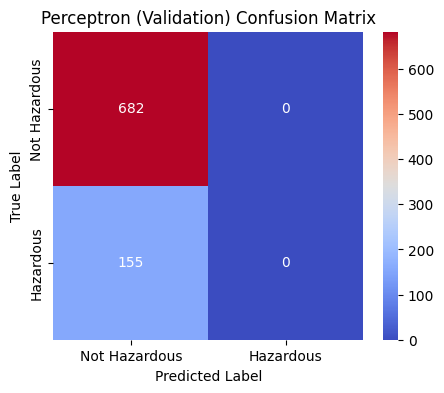


  Accuracy:  0.8148
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Evaluation Metrics for Perceptron (Test):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


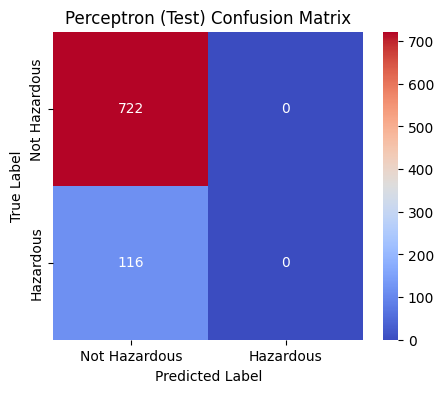


  Accuracy:  0.8616
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.8615751789976134, 0.0, 0.0, 0.0)

In [73]:
evaluate_model(y_valid_numpy, y_valid_pred_nn, "Perceptron (Validation)")
evaluate_model(y_test_numpy, y_test_pred_nn, "Perceptron (Test)")

In [86]:
from sklearn.naive_bayes import GaussianNB

In [88]:
X_train_nb = np.array(X_train)
X_valid_nb = np.array(X_valid)
X_test_nb = np.array(X_test)

In [89]:
y_train_nb = np.array(y_train)
y_valid_nb = np.array(y_valid)
y_test_nb = np.array(y_test)

In [90]:
naiveBayes = GaussianNB()

In [91]:
naiveBayes.fit(X_train_nb, y_train_nb)

GaussianNB()

In [92]:
y_valid_pred_nb = naiveBayes.predict(X_valid_nb)

In [93]:
y_test_pred_nb = naiveBayes.predict(X_test_nb)


Evaluation Metrics for Naïve Bayes (Validation):


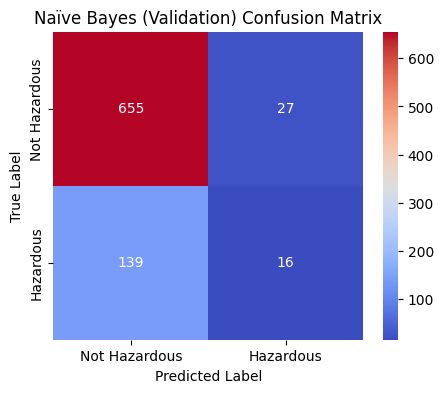


  Accuracy:  0.8017
  Precision: 0.3721
  Recall:    0.1032
  F1-score:  0.1616

Evaluation Metrics for Naïve Bayes (Test):


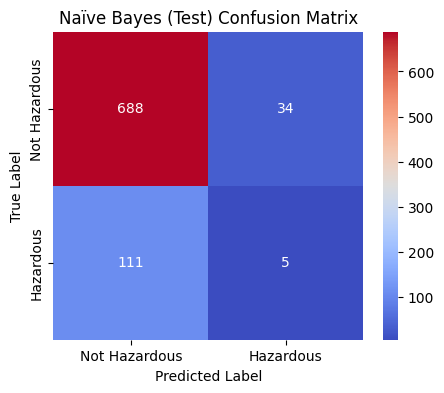


  Accuracy:  0.8270
  Precision: 0.1282
  Recall:    0.0431
  F1-score:  0.0645


(0.8269689737470167,
 0.1282051282051282,
 0.04310344827586207,
 0.06451612903225806)

In [94]:
evaluate_model(y_valid_nb, y_valid_pred_nb, "Naïve Bayes (Validation)")
evaluate_model(y_test_nb, y_test_pred_nb, "Naïve Bayes (Test)")

In [95]:
from sklearn.neighbors import KNeighborsClassifier

In [99]:
X_train_knn = np.array(X_train)
X_valid_knn = np.array(X_valid)
X_test_knn = np.array(X_test)

In [100]:
y_train_knn = np.array(y_train)
y_valid_knn = np.array(y_valid)
y_test_knn = np.array(y_test)

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [112]:
def mahalanobis_distance(x, mean, inv_cov_matrix):
    diff = x - mean
    mahal_dist = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
    return mahal_dist

In [103]:
from collections import Counter

In [113]:
def knn_mahalanobis(X_train, y_train, X_test, K):
    mean_vector = np.mean(X_train, axis=0)  # Compute mean of training data
    cov_matrix = np.cov(X_train.T)
    inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Compute pseudo-inverse for stability
    y_pred = []

    for x in X_test:
        distances = [mahalanobis_distance(x, X_train[i], inv_cov_matrix) for i in range(len(X_train))]
        k_nearest_indices = np.argsort(distances)[:K]
        k_nearest_labels = y_train[k_nearest_indices]
        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
        y_pred.append(most_common_label)

    return np.array(y_pred)

In [114]:
k_values = [1, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]
accuracies = []
for k in k_values:
    y_valid_pred = knn_mahalanobis(X_train_knn, y_train_knn, X_valid_knn, k)
    acc = accuracy_score(y_valid_knn, y_valid_pred)
    accuracies.append(acc)

# Find the best K
best_k = k_values[np.argmax(accuracies)]

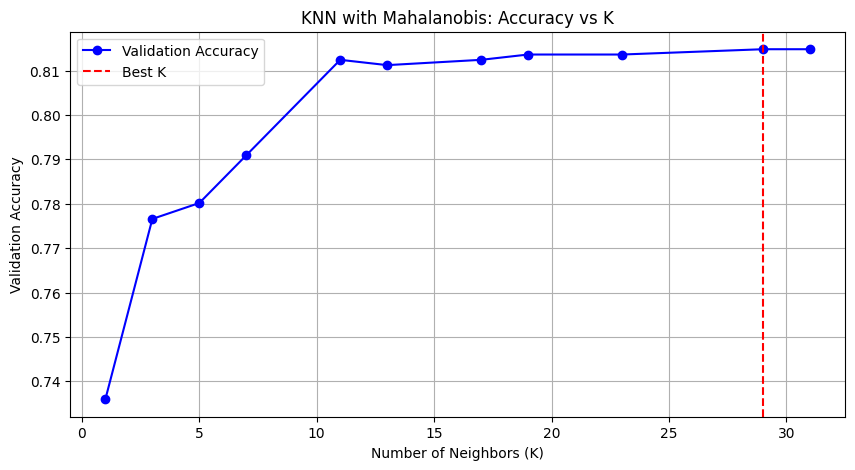

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue', label="Validation Accuracy")
plt.axvline(x=best_k, color='red', linestyle='--', label="Best K")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Validation Accuracy")
plt.title("KNN with Mahalanobis: Accuracy vs K")
plt.legend()
plt.grid()
plt.show()

In [116]:
mean_vector = np.mean(X_train_knn, axis=0)
cov_matrix = np.cov(X_train_knn.T)
inv_cov_matrix = np.linalg.pinv(cov_matrix)
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="mahalanobis", metric_params={"VI": inv_cov_matrix})
knn_final.fit(X_train_knn, y_train_knn)


KNeighborsClassifier(metric='mahalanobis',
                     metric_params={'VI': array([[ 6.96226913e-31,  3.43125915e-31, -3.67020683e-31,
        -3.59998139e-34, -5.31192854e-31, -3.10145830e-31,
        -4.24286388e-31,  8.58407396e-31,  6.60779551e-32,
        -4.38870384e-31, -1.15157167e-31, -1.61511826e-31,
        -2.37343479e-31,  1.62165475e-31,  2.43369641e-31,
        -8.89839919e-32,  7.62342508e-32, -2.87007773e-31...
        -4.67739730e-35, -6.66812096e-32, -3.89327481e-32,
        -5.32611126e-32,  1.07756581e-31,  8.29486401e-33,
        -5.50918518e-32, -1.44558320e-32, -2.02747111e-32,
        -2.97939822e-32,  2.03566876e-32,  3.05503432e-32,
        -1.11703105e-32,  9.56964716e-33, -3.60283605e-32,
         1.05390896e-31,  9.19183917e-33, -3.20393147e-26,
        -2.30659785e-23, -5.57024333e-34,  1.09711869e-32,
        -5.57024333e-34,  1.09711869e-32]])},
                     n_neighbors=29)

In [120]:
y_valid_pred_knn = knn_final.predict(X_valid_knn)
y_test_pred_knn = knn_final.predict(X_test_knn)


Evaluation Metrics for KNN with Mahalanobis (Validation):


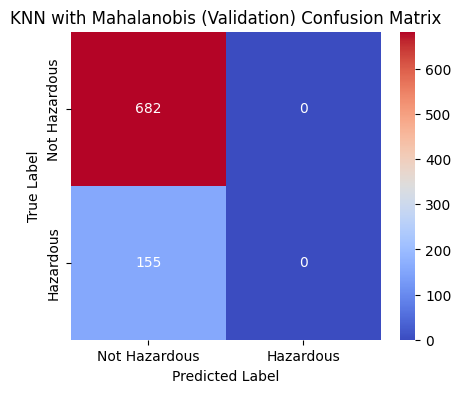

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



  Accuracy:  0.8148
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Evaluation Metrics for KNN with Mahalanobis (Test):


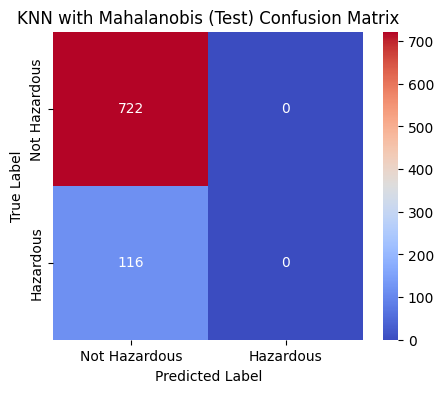


  Accuracy:  0.8616
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.8615751789976134, 0.0, 0.0, 0.0)

In [121]:
evaluate_model(y_valid_knn, y_valid_pred_knn, "KNN with Mahalanobis (Validation)")
evaluate_model(y_test_knn, y_test_pred_knn, "KNN with Mahalanobis (Test)")
